<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Make-counterfactual-graph" data-toc-modified-id="Make-counterfactual-graph-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Make counterfactual graph</a></span></li><li><span><a href="#Walkthrough-of-make-counterfactual-graph" data-toc-modified-id="Walkthrough-of-make-counterfactual-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Walkthrough of make counterfactual graph</a></span></li><li><span><a href="#ID*-algorithm" data-toc-modified-id="ID*-algorithm-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ID* algorithm</a></span></li><li><span><a href="#IDC*-algorithm" data-toc-modified-id="IDC*-algorithm-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>IDC* algorithm</a></span></li><li><span><a href="#Walkthrough-of-IDC*" data-toc-modified-id="Walkthrough-of-IDC*-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Walkthrough of IDC*</a></span><ul class="toc-item"><li><span><a href="#Line-2-of-IDC*" data-toc-modified-id="Line-2-of-IDC*-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Line 2 of <strong>IDC*</strong></a></span></li><li><span><a href="#Line-4-of-IDC*" data-toc-modified-id="Line-4-of-IDC*-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Line 4 of <strong>IDC*</strong></a></span></li></ul></li><li><span><a href="#Line-6" data-toc-modified-id="Line-6-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Line 6</a></span><ul class="toc-item"><li><span><a href="#Line-9" data-toc-modified-id="Line-9-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Line 9</a></span></li></ul></li></ul></div>

In [1]:
%load_ext lab_black

# Make counterfactual graph

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$


**Lemma 24** Let $M$ be a model inducing $G$ containing variables $\alpha,\beta$ with the following properties: 
* $\alpha$ and $\beta$ have the same domain of values.
*  There is a bijection $f$ from $Pa(\alpha)$ to $Pa(\beta)$ such that a parent $\gamma$ and $f(\gamma)$ have the same domain of values. 
* The functional mechanisms of $\alpha$ and $\beta$ are the same (except whenever the function for $\alpha$ uses the parent $\gamma$, the corresponding function for $\beta$ uses $f (\gamma)$). 

Assume an observable variable set $\mathbf Z$ was observed to attain values $\mathbf{z}$ in $M_\mathbf{x}$, the submodel obtained from $M$ by forcing another observable variable set $\mathbf X$ to attain values $\mathbf x$. Assume further that for each $\gamma\in Pa(\alpha)$, either $f (\gamma) = \gamma$, or $\gamma$ and $f (\gamma)$ attain the same values (whether by observation or intervention). Then $\alpha$ and $\beta$ are the same random variable in $M_{\mathbf x}$ with observations $\mathbf z$.

$\textbf{Lemma 25}$. Let $M_\mathbf{x}$ be a submodel derived from $M$ with set $\mathbf Z$ observed to attain values $\mathbf z$, such that Lemma 24 holds for $\alpha, \beta$. Let $M'$ be a causal model obtained from $M$ by merging $\alpha, \beta$ into a new node $\omega$, which inherits all parents and the functional mechanism of $\alpha$. All children of $\alpha,\beta$ in $M'$ become children of $\omega$. Then $M_\mathbf{x}$,  $M'_\mathbf{x}$ agree on any distribution consistent with $\mathbf{z}$ being observed.



$\text{function }\mathbf{ make-cg}\left(G, \gamma\right) \\ \text{INPUT: } \text{ $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  A counterfactual graph $G_\gamma$ and either a set of events $\gamma'$ such that $P(\gamma') = P(\gamma)$ or $\mathbf{Inconsistent}$} $

* Construct a submodel $G_{\mathbf{X}_i}$ for each action $do(\mathbf{x}_i)$ mentioned in $\gamma$. Construct the parallel worlds graph $G'$ by having all such graphs share their corresponding $U$ nodes.

* Let $\pi$ be a topological ordering of nodes in $G'$, let $\gamma':=\gamma.$
* Apply Lemmas 24 and 25, in order $\pi$ to each observable node pair $\alpha, \beta$ derived from the same variable in $G$. For each $\alpha, \beta$ that are the same, do:
    * Let $G'$ be modified as specified in Lemma 25
    * Modify $\gamma'$ by renaming all occurrences of $\beta$ to $\alpha$.
    * If $\mathbf{val}(\alpha)\neq \mathbf{val}(\beta)$, return $G', \mathbf{Inconsistent}$.
* $\texttt{return}$ $(G'_{An(\gamma')}, \gamma')$, where $An(\gamma')$ is the set of nodes in $G'$ ancestral to nodes corresponding to variables mentioned in $\gamma'$.

$$P(\lnot rxn_{do(\lnot catalyst)} | rxn, catalyst)$$

# Walkthrough of make counterfactual graph

In [1]:
from y0.algorithm.identify.id_star import (
    id_star,
    is_event_empty,
    violates_axiom_of_effectiveness,
    remove_event_tautologies,
    id_star_line_4,
    id_star_line_6,
    id_star_line_8,
    id_star_line_9,
    get_district_domains,
    domain_of_counterfactual_values,
    is_self_intervened,
    sub,
)

from y0.algorithm.identify.cg import (
    make_parallel_worlds_graph,
    extract_interventions,
    make_counterfactual_graph,
    has_same_parents,
    has_same_function,
)
from y0.graph import NxMixedGraph
from y0.examples import (
    figure_9a,
    figure_9b,
    figure_9c,
    figure_9d,
    figure_11a,
    figure_11b,
    figure_11c,
)
from y0.dsl import (
    X,
    D,
    W,
    P,
    Y,
    Z,
    Event,
    CounterfactualVariable,
    Intervention,
    _get_treatment_variables,
    Variable,
    Zero,
)

x, y, z, w, d = -X, -Y, -Z, -W, -D
import matplotlib.pyplot as plt

We illustrate the operation of make-cg by showing how the graph in Fig. 9 (c) is derived from the graph in Fig. 9 (b). We start the application of Lemma 24 from the topmost observable nodes, and conclude that the node pairs $D_x, D$, and $X_d, X$ have the same functional mechanisms, and the same parent set (in this case the parents are unobservable nodes $U_d$ for the first pair, and $U$ for the second). We then use Lemma 25 to obtain the graph shown in Fig. 11 (a). 
Since the node pairs are the same, we pick the name of one of the nodes of the pair to serve as the name of the new node. In our case, we picked D and X . Note that for this graph, and all subsequent intermediate graphs we generate, we use the convention that if a merge creates a situation where an unobservable variable has a single child, that variable is omitted from the graph. For instance, in Fig. 11 (a), the variable $U_d$ , and its corresponding arrow to $D$ omitted. 

In [5]:
cf_graph_1 = lemma_25(figure_9b.graph, D, D @ ~X)
cf_graph_2 = lemma_25(cf_graph_1, X, X @ D)
cf_graph_3 = lemma_25(cf_graph_2, Z, Z @ X)
cf_graph_4 = lemma_25(cf_graph_3, Z, Z @ D)
cf_graph_5 = lemma_25(cf_graph_4, W, W @ D)
cf_graph_6 = lemma_25(cf_graph_5, D, D @ D)
cf_graph_7 = lemma_25(cf_graph_6, Y, Y @ D)
figure_11a_calculated = cf_graph_3
figure_11b_calculated = cf_graph_6
figure_11c_calculated = cf_graph_7

<IPython.core.display.Javascript object>

In [4]:
X == ~X

False

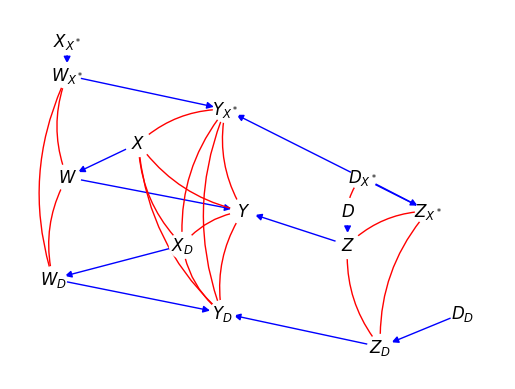

In [3]:
figure_9b.graph.draw()

In [5]:
W @ X

W @ -X

In [7]:
~W

+W

In [8]:
P(Y @ X | ~X, Z @ D, D)

P(Y @ -X | D, +X, Z @ -D)

In [11]:
{Y @ X: y}, {Y@ X: ~y}

({Y @ -X: -Y}, {Y @ -X: +Y})

In [13]:
P(+Y @ +X)

P(+Y @ +X)

In [16]:
P({Y @ +x: y})

P(Y @ +X)

# ID* algorithm


$\text{function }\mathbf{ID^*}\left(G, \gamma\right) \\ \text{INPUT: }\text{  $G$ a causal diagram, $\gamma$ a conjunction of counterfactual events}. \\  \text{OUTPUT:  Expression for $P(\gamma)$ in terms of $P_*$ or $\mathbf{FAIL}$} $


The notation used in these algorithms is somewhat intricate, so we give an intuitive description of each line. We start with **ID***.



The first line states that if $\gamma$ is an empty conjunction, then its probability is 1, by convention. 

1. if $\gamma=0$ return $1$

In [10]:
from y0.algorithm.identify.id_star import is_event_empty
from y0.dsl import One
event = {}
if is_event_empty(event):
    display(One())

One()

The second line states that if $\gamma$ contains a counterfactual which violates the Axiom of Effectiveness (Pearl, 2000), then $\gamma$ is inconsistent, and we return probability 0.

2. if $(\exists x_x'\in \gamma)$, return $0$ 

In [11]:
from y0.algorithm.identify.id_star import violates_axiom_of_effectiveness
event = {X @ -x: +x}
if violates_axiom_of_effectiveness( event ):
    display(Zero())


Zero()

The third line states that if a counterfactual contains its own value in the subscript, then it is a tautological event, and it can be removed from $\gamma$ without affecting its probability. 

3. if $(\exists x_x\in \gamma)$, return $\mathbf{ID^*}(G, \gamma\backslash\{x_x,..\})$

In [14]:
event = {X @ -x: -x, Y @ -x: -y}
reduced_event = remove_event_tautologies( event )
if reduced_event != event:
    print(f"recurring on reduced event {reduced_event}")
    

recurring on reduced event {Y @ -X: -Y}


Line 4 invokes `make-cg` to construct a counterfactual graph $G'$ , and the corresponding relabeled counterfactual $\gamma'$ 

4.  in $(G',\gamma')= $ **make-cg**$(G,\gamma)$. 

 

None

{Y @ +X: +Y, X: +X, Z @ -D: -Z, D: -D}

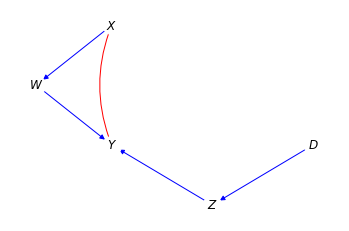

In [23]:
from y0.algorithm.identify.id_star import id_star_line_4
graph = figure_9a.graph
display(graph.draw())
event = {Y @ +x: +y, X: +x, Z @ -d: -z, D: -d} 
event

None

{Y @ +X: +Y, X: +X, D: -D, Z: -Z}

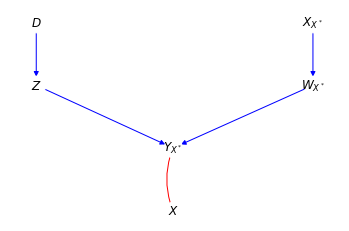

In [24]:
new_graph, new_event = id_star_line_4( graph, event )
display(new_graph.draw())
new_event

Line 5 returns probability 0 if an inconsistency was found during the construction of the counterfactual graph, for example, if two variables found to be the same in γ had different value assignments. 

5. if $\gamma' = $ **INCONSISTENT**, return 0

In [34]:
# when the value of D is observed to be -d, the value of Z is -z, but when D is forced to be -d, the value of Z is +z. 
# This is inconsistent.
event = {Z @ -d: +z, Z: -z, D: -d} 
graph = figure_9a.graph
new_graph, new_event = id_star_line_4( graph, event )
if new_event is None:
    print(f"event {event} is inconsistent")
    display(Zero())

event {Z @ -D: +Z, Z: -Z, D: -D} is inconsistent


Zero()

Line 6 is analogous to Line 4 in the ID algorithm, it decomposes the problem into a set of subproblems, one for each C-component in the counterfactual graph. In the ID algorithm, the term corresponding to a given C-component $S_i$ of the causal diagram was the effect of all variables not in $S_i$ on variables in $S_i$ , in other words $P_{\mathbf{v}\backslash s_i} (s_i )$, and the outermost summation on line 4 was over values of variables not in $\mathbf{Y},\mathbf{X}$. Here, the term corresponding to a given C-component $S^i$ of the counterfactual graph $G'$ is the conjunction of counterfactual variables where each variable contains in its subscript all variables not in the C-component $S^i$ , in other words $\mathbf{v}(G' )\backslash s^i$ , and the outermost summation is over observable variables not in $\gamma'$ , that is over $\mathbf{v}(G')\backslash \gamma'$ , where we interpret $\gamma'$ as a set of counterfactuals, rather than a conjunction. 

6. if $C(G') = \{S^1, \ldots, S^k\}$, return $\sum_{V(G')\backslash\gamma'}\prod_i\mathbf{ID^*}(G, s^i_{v(G')\backslash s^i})$

Line 7 is the base case, where our counterfactual graph has a single Ccomponent. 

7. if $C(G')= \{S\}$ then,

There are two cases, corresponding to line 8 and line 9. 

     
Line 8 says that if γ 0 contains a “conflict,” that is an inconsistent value assignment where at least one value is in the subscript, then we fail. 

8. if $(\exists\mathbf{x},\mathbf{x'})$ s.t. $x\not=\mathbf{x'}, \mathbf{x}\in \mathbf{sub}(S), \mathbf{x'}\in \mathbf{ev}(S)$, throw **FAIL**

Line 9 says if there are no conflicts, then its safe to take the union of all subscripts in γ 0 , and return the effect of the subscripts in γ 0 on the variables in γ 0 . 


9. else, let $\mathbf{x} = \cup\mathbf{sub}(S)$ return $P_\mathbf{x}(\mathbf{var}(S))$

# IDC* algorithm

The **IDC***, like its counterpart **IDC**, is shorter. 


The first line fails if $\gamma$ is inconsistent. **IDC** did not have an equivalent line, since we can assume $P(\mathbf{v})$ is positive. The problem with counterfactual distributions is there is no simple way to prevent non-positive distributions spanning multiple worlds from arising, even if the original P(v) was positive—hence the explicit check. 

1. if $\mathbf{ID*}(G,\delta)=0$, return **UNDEFINED**

The second line constructs the counterfactual graph, except since make-cg can only take conjunctions, we provide it with a joint counterfactual γ ^ δ. 

2. $(G',\gamma'\wedge\delta')=\mathbf{make-cg}(G,\gamma\wedge\delta)$

Line 3 returns 0 if an inconsistency was detected. 

3. if $\gamma'\wedge\delta' =$  **INCONSISTENT**, return $0$


Line 4 of **IDC*** is the central line of the algorithm and is analogous to line 1 of **IDC**. In **IDC**, we moved value assignment $Z = z$ from being observed to being fixed if there were no back-door paths from $Z$ to the outcome variables $\mathbf{Y}$ given the context of the effect of $do(\mathbf{x})$. Here in **IDC***, we move a counterfactual value assignment $Y_\mathbf{x} = y$ from being observed (that is being a part of $\delta$), to being fixed (that is appearing in every subscript of $\gamma'$) if there are no back-door paths from $Y_\mathbf{x}$ to the counterfactual of interest $\gamma'$.

$$\newcommand\ci{\perp\!\!\!\perp}$$
$$\newcommand{\ubar}[1]{\underset{\bar{}}{#1}}
\newcommand{\obar}[1]{\overset{\bar{}}{#1}}$$

4. if $(\exists y_\mathbf{x}\in\delta')$ s.t. $(Y_\mathbf{x} \ci \gamma')G'_{\ubar{y\mathbf{x}}}$, return $\mathbf{IDC^*}(G, \gamma'_{y\mathbf{X}},\delta'\backslash\{y_{\mathbf{X}}\})$

Finally, line 5 of **IDC*** is the analogue of line 2 of **IDC**, we attempt to identify a joint counterfactual probability, and then obtain a conditional counterfactual probability from the result.

5. else, let $P'=\mathbf{ID^*}(G,\gamma'\wedge\delta')$. return $\frac{P'}{P'(\delta)}$

[IDC*](images/Figure12b-IDC_star.png)

NameError: name 'figure_9b_calculated' is not defined

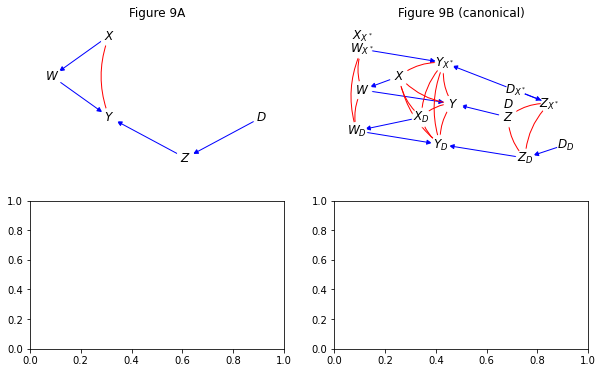

<IPython.core.display.Javascript object>

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6.0))

figure_9a.graph.draw(ax=axes[0][0], title="Figure 9A")
figure_9b.graph.draw(ax=axes[0][1], title="Figure 9B (canonical)")
figure_9b_calculated.draw(ax=axes[1][0], title="Figure 9B (calculated)")
figure_9c.graph.draw(ax=axes[1][1], title="Figure 9C")
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(10, 6.0))

figure_11a.graph.draw(ax=axes[0][0], title="Figure 11a (expected)")
figure_11a_calculated.draw(ax=axes[0][1], title="Figure 11a (actual)")
figure_11b.graph.draw(ax=axes[1][0], title="Figure 11b (expected)")
figure_11b_calculated.draw(ax=axes[1][1], title="Figure 11b (actual)")
figure_11c.graph.draw(ax=axes[2][0], title="Figure 11c (expected)")
figure_11c_calculated.draw(ax=axes[2][1], title="Figure 11c (actual)")

plt.show()

Next, we apply Lemma 24 for the node pair Wd ; W . In this case, the functional mechanisms are once again the same, while the parents of Wd ; W are X and Uw . We can also apply Lemma 24 twice to conclude that Z ; Z x and Z d are in fact the same node, and so can be merged. The functional mechanisms of these three nodes are the same, and they share the parent U z . As far as the parents of this triplet, the Uz parent is shared by all three, while Z ; Z x share the parent D, and Z d has a separate parent d , fixed by intervention. However, in our counterfactual query, which is P(y x jx 0 ; z d ; d ), the variable D happens to be observed to attain the value d , the same as the intervention value for the parent of Z d . This implies that for the purposes of the Z ; Z x ; Z d triplet, their D-derived parents share the same value, which allows us to conclude they are the same random variable. The intuition here is that while intervention and observation are not the same operation, they have the same effect if the relevant U variables happen to react in the same way to both the given intervention, and the given observation (this is the essence of the Axiom of Composition discussed by Pearl (2000).) In our case, U variables react the same way because the parallel worlds share all unobserved variables. 

# Walkthrough of `ID*` and `IDC*`

![idc_star_walkthrough](images/idc_star_walkthrough.png) -->



We illustrate the operation of these algorithms by considering the identification of a query $P(y_x  | x',  z_d, d )$ we mentioned earlier.

Since $P(x', z_d, d )$ is not inconsistent (`IDC*` line 1), 

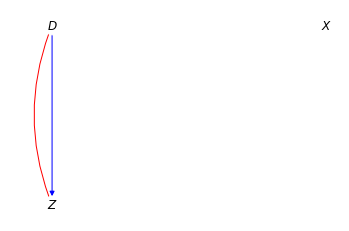

In [8]:
new_event

{X: +X, D: -D, Z: -Z}

we proceed to construct the counterfactual graph on line 2

In [4]:
delta = {X: +x, Z @ -d: -z, D: -d}
gamma = {Y @ -x: +y}
gamma_and_delta = {**gamma, **delta}

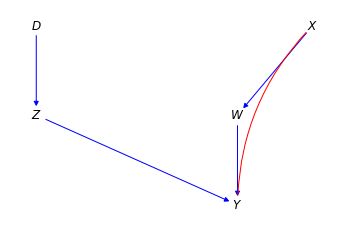

In [6]:
new_graph, new_event = make_counterfactual_graph(figure_9a.graph, gamma_and_delta)
new_graph.draw()

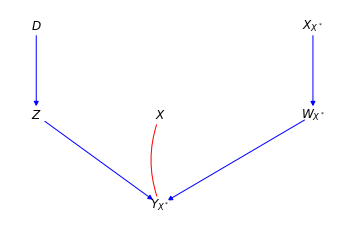

In [7]:
new_graph, new_event = make_counterfactual_graph(
    figure_9a.graph, {Y @ +x: +y, X: -x, Z: -z, D: -d}
)
new_graph.draw()

Suppose we produce the graph in Fig. 9 (c), where the corresponding modified query is $P(y_x | x',  z, d )$. 

Since $P(y_x | x',  z, d )$ is not inconsistent we proceed to the next line, which moves $z, d$ (with $d$ being redundant due to graph structure) to the subscript of $y_x$, to obtain
$P(y_{x,z} | x')$, and calls `IDC*` with this query recursively.

Note that since the subscripts in one of the variables of our query changed, the counterfactual graph generated will change  as well

In particular, the invocation of `make-cg` with the joint distribution from  which $P(y_{x,z}|x')$ is derived, namely $P(y_{x,z}, x')$ will result in the graph shown in Fig. 9 (d).

Since $X'$ has a back-door path to $Y_{x,z}$ in this graph, we can no longer call `IDC*` recursively, so we invoke `ID*` with the query $P(y_{x,z},x')$.

In [16]:
{Y @ (+x, -z): +y, X: -x}

{Y @ (+X, -Z): +Y, X: -X}

The first interesting line in <b>ID*</b> is line $6$, which first computes $P(y_{x,z}, w_{x, z},  x' )$ by C-component factorization

and then computes $P(y_{x,z}, x' )$ from $P(y_{x, z}, w_{x, z}, x' )$ by marginalizing over $W_{x,z}$ Since the counterfactual graph for this query (Fig. 9 (d)) has two C-components, $\{Y_{x,z}, X\}$ and $\{W_{x,z}\}$, $P(y_{x,z}, w_{x,z}, x' ) = P(y_{x,z,w}, x'_w )P(w_{x, z} )$, <span style="background-color: #FFFF00">which can be simplified by removing redundant subscripts</span> to $P(y_{z,w}, x' )P(w_x )$.

Line 6 then recursively calls `ID*` with $P(y_{x,z,w},x')$ and $P(w_x)$, multiplies the results and marginalizes over $W_x$.  

The first recursive call reaches line 9 with $P(y_{z,w}, x')$, which means our query is identifiable as $P'=\sum_w P_{z,w}(y,x')P_x(w)$ and the conditional query is $P'/P'(x')$.

## Line 2 of **IDC***

We illustrate the operation of these algorithms by considering the identification of a query $P(y_x |x', z_d, d)$ we mentioned earlier.  Since $P(x, z_d, d)$ is not inconsistent, we proceed to construct the counterfactual graph on line 2.  Suppose we produce the counterfactual graph Figure 9(c) where the corresponding modified query is $P(y_x|x',z,d)$.  

In [ ]:
new_graph, new_query = make_counterfactual_graph(figure_9a.graph, P(Y @ ~X, X, Z, D))
display(new_query)
new_graph.draw()

## Line 4 of **IDC***

Since $P(y_x, x', z, d)$ is not inconsistent, we proceed to line 4, which moves $z,d$ (with $d$ being redundant due to graph strucure) to the subscript of $y_x$, to obtain $P(y_{x,z}|x')$, and calls **IDC*** with this query recursively. Note that since the subscripts in one of the variables of our query changed, the counterfactual graph generated will change as well.  In particular, the invocation of **make-cg** with the joint distribution from which $P(y_{x,z}|x')$ is derived, namely $P(y_{x,z},x')$, will result in the graph shown in Fig. 9(d).



In [ ]:
from y0.graph import NxMixedGraph
from y0.dsl import Probability
from typing import Tuple
from y0.algorithm.identify.id_star import get_worlds


def make_counterfactual_graph(
    graph: NxMixedGraph[Variable], query: Probability
) -> Tuple[NxMixedGraph[Variable], Probability]:
    """Make counterfactual graph"""
    worlds = get_worlds(query)
    pw_graph = make_parallel_worlds_graph(graph, worlds)
    new_query_variables = set(query.distribution.children)
    cf_graph = NxMixedGraph.from_edges(
        nodes=pw_graph.nodes(),
        directed=pw_graph.directed.edges(),
        undirected=pw_graph.undirected.edges(),
    )
    for node in graph.topological_sort():
        for intervention in worlds:
            if (
                (node in cf_graph.nodes())
                and (node @ intervention in cf_graph.nodes())
                and lemma_24(cf_graph, node, node @ intervention)
            ):
                cf_graph = lemma_25(cf_graph, node, node @ intervention)
                if node @ intervention in new_query_variables:
                    new_query_variables = new_query_variables - {
                        node @ intervention
                    } | {node}

        if len(worlds) > 1:
            for intervention1, intervention2 in combinations(worlds, 2):
                if (
                    (node @ intervention1 in cf_graph.nodes())
                    and (node @ intervention2 in cf_graph.nodes())
                    and lemma_24(cf_graph, node @ intervention1, node @ intervention2)
                ):
                    cf_graph = lemma_25(
                        cf_graph, node @ intervention1, node @ intervention2
                    )
                    if node @ intervention2 in new_query_variables:
                        new_query_variables = new_query_variables - {
                            node @ intervention2
                        } | {node @ intervention1}
    return cf_graph.subgraph(cf_graph.ancestors_inclusive(new_query_variables)), P(
        new_query_variables
    )


def make_counterfactual_graph2(
    graph: NxMixedGraph[Variable], query: Probability
) -> Tuple[NxMixedGraph[Variable], Probability]:
    """Make counterfactual graph"""
    worlds = get_worlds(query)
    pw_graph = make_parallel_worlds_graph(graph, worlds)
    new_query_variables = set(query.distribution.children)
    cf_graph = NxMixedGraph.from_edges(
        nodes=pw_graph.nodes(),
        directed=pw_graph.directed.edges(),
        undirected=pw_graph.undirected.edges(),
    )
    for node in graph.topological_sort():
        for intervention in worlds:
            if (
                (node in cf_graph.nodes())
                and (node @ intervention in cf_graph.nodes())
                and lemma_24(cf_graph, node, node @ intervention)
            ):
                cf_graph = lemma_25(cf_graph, node, node @ intervention)
                if node @ intervention in new_query_variables:
                    new_query_variables = new_query_variables - {
                        node @ intervention
                    } | {node}

        if len(worlds) > 1:
            for intervention1, intervention2 in combinations(worlds, 2):
                if (
                    (node @ intervention1 in cf_graph.nodes())
                    and (node @ intervention2 in cf_graph.nodes())
                    and lemma_24(cf_graph, node @ intervention1, node @ intervention2)
                ):
                    cf_graph = lemma_25(
                        cf_graph, node @ intervention1, node @ intervention2
                    )
                    if node @ intervention2 in new_query_variables:
                        new_query_variables = new_query_variables - {
                            node @ intervention2
                        } | {node @ intervention1}
    display(cf_graph.draw())
    display(new_query_variables)
    return cf_graph.subgraph(cf_graph.ancestors_inclusive(new_query_variables)), P(
        new_query_variables
    )

In [ ]:
input_query = P(Y @ (Z, ~X), X)
input_graph = figure_9a.graph
actual_graph, actual_query = make_counterfactual_graph(input_graph, input_query)
actual_graph.draw()

In [ ]:
backdoor = NxMixedGraph.from_edges(
    directed=[
        (Z, X),
        (Z, Y),
        (X, Y),
    ]
)
backdoor.intervene([X]).draw()

In [ ]:
backdoor.intervene([~X]).draw()

In [ ]:
interventions = {Z, ~X}
nodes = set(backdoor.nodes()    )
for intervention in interventions:
    if intervention not in nodes:
        if ~intervention in nodes:
            
        

In [ ]:
worlds = get_worlds(P( Y @ (Z, ~X), X))
worlds

In [ ]:
figure_9a.graph.draw()

In [ ]:
double_intervention_world = figure_9a.graph.intervene([Z, ~X])
double_intervention_world.draw()

In [ ]:
intervention = ~X
type(~intervention)

In [ ]:
pw_graph =     make_parallel_worlds_graph(figure_9a.graph, worlds)
pw_graph.draw()

In [ ]:
sorted(_get_treatment_variables((Y @ (Z, ~X)).get_variables()), key=lambda x: str(x))

In [ ]:
sorted(get_worlds(input_query))

In [ ]:
graph = NxMixedGraph.from_edges(
    nodes=(X, X @ (Z, ~X), Z, W @ (Z, ~X), Y @ (Z, ~X)),
    directed=[(X @ (Z, ~X), W @ (Z, ~X)), (Z, Y @ (Z, ~X)), (W @ (Z, ~X), Y @ (Z, ~X))],
    undirected=[(X, Y @ (Z, ~X))],
)
graph.draw()

In [ ]:
from y0.mutate import canonicalize

ordering = sorted(P(Y @ (Z, ~X), X).get_variables(), key=lambda x: str(x))
ordering

![idc_star_walkthrough](images/idc_star_walkthrough.png)

In [ ]:
query = P(Y@~X | X, Z, D)
query.children

In [ ]:
query.parents + query.children

# Line 6

The first interesting line in **ID*** is line 6, which first computes $P(y_{x,z}, w_{x,z}, x')$ by marginalization over $W_{x,z}$.  Since the counterfactual graph for this query (Fig 9 (d)) has two C-components, $\{Y_{x,z}, X\}$ and $W_{x,z}$, $P(y_{x,z}, w_{x,z}, x') = P(y_{x,z,w},x'_w)P(w_x)$, which can be simplified by removing redundant subscripts to $P(y_{z,w},x')P(w_x)$.  Line 6 then recursively calls **ID*** with $P(y_{x,z,w},x')$ and $P(w_x)$, which means our query is identifiable as $P'=\sum_wP_{z,w}(y,x')P_x(w)$ and the conditional query is equal to $P'/P'(x')$.

In [ ]:
figure_9d.graph.draw()

## Line 9

The first recursive call reaches line 9 with $P(y_{z,w}, x')$ which is identifiable as $P_{z,w}(y,x')$ from $P_*$.  

In [ ]:
from y0.algorithm.identify.id_star import id_star_line_9

id_star_line_9(figure_9a.graph, P(Y @ {Z, W}, X))

In [ ]:
foo = set()
foo.add(Variable('A'))
foo.add(Variable('B'))
foo.add(Variable('A'))
foo

In [ ]:
Xprime = Variable("X^*")

input_query = P(Y @ {Z, W}, Xprime)
output_query = P[Z, W](Y, Xprime)
display(input_query)
display(output_query)

In [ ]:
from y0.graph import NxMixedGraph
from y0.dsl import Variable, Probability, Intervention
from itertools import combinations
from typing import Collection, Tuple
from networkx.algorithms.dag import topological_sort
from networkx import DiGraph
from y0.algorithm.identify.id_star import get_worlds

In [ ]:
sorted(set([frozenset(['a','b']), frozenset(['b','e']), frozenset(['e','b'])]))

In [ ]:
graph = figure_9a.graph
figure_9_query = P(Y @ ~X, X, Z @ D, D)

worlds = get_worlds(figure_9_query)
pw_graph = make_parallel_worlds_graph( graph, worlds)

In [ ]:
from y0.dsl import Intervention
{v for v in figure_9_query.get_variables() if not isinstance(v, Intervention)}

In [ ]:
dir(figure_9_query.distribution)

In [ ]:
X @ ~X

In [ ]:
figure_9_query.distribution.parents

In [ ]:
query = P( Y @ ~X | X, Z @ D, D )
query.distribution.parents

In [ ]:
from y0.algorithm.identify.id_star import make_counterfactual_graph
graph, query = make_counterfactual_graph( figure_9a.graph, figure_9_query)
display(query)
graph.draw()

In [ ]:
dir(X@ ~X)

In [ ]:
node = X @ ~X
node.given()

In [ ]:
figure_9b_calculated == str_nodes_to_expr_nodes(figure_9b.graph)

In [ ]:
admg = figure_9b_calculated.to_admg()
lvm= admg_to_latent_variable_dag(admg)

In [ ]:

for var1, var2 in combinations(figure_9_query.get_variables(), 2):
    if var1.name == var2.name:
        print(var1, var2, var1.name, var2.name)
        if isinstance(var1, Intervention) and isinstance(var2, Intervention):
            print("var1 == var2", var1.star == var2.star)
        elif isinstance(var1, Intervention):
            print("var1 ", var1.star, var2)
        elif isinstance(var2, Intervention):
            print(var1, "var2", var2.star)
        else:
            print(var1, var2)

In [ ]:
figure_9_query

In [ ]:

cf_vars = [var for var in figure_9_query.get_variables()
          if isinstance(var, CounterfactualVariable)]
worlds = [_get_treatment_variables(cf.get_variables()) for cf in cf_vars]
isinstance(~X, Variable)

In [ ]:
_get_treatment_variables(Y@ (~X, Z)

In [ ]:
from y0.graph import admg_from_latent_variable_dag, admg_to_latent_variable_dag
from IPython.display import Image
import networkx as nx
admg = figure_9b.graph.to_admg()
lvm = admg_to_latent_variable_dag(admg)
lvm_agraph = nx.nx_agraph.to_agraph(lvm)
lvm_agraph.layout(prog="dot")
lvm_agraph.draw("figure_9b_lvm.png")
Image("figure_9b_lvm.png")

In [ ]:
def combine_parallel_worlds_lvm(
    graph: NxMixedGraph[Variable],
    combined_worlds: Collection[NxMixedGraph[Variable]],
    worlds: Collection[Collection[Variable]],
) -> NxMixedGraph[Variable]:
    """Stitch together parallel worlds through the magic of latent variables"""
    # get all the undirected edges in all the parallel worlds
    undirected = [(u, v) for world in combined_worlds for u, v in world.undirected.edges()]
    # Stitch together counterfactual variables with observed variables
    undirected += [
        (u, u @ treatments)
        for treatments in worlds
        for u in graph.nodes()
        # Don't add an edge if a variable is intervened on
        if (u not in treatments) and (~u not in treatments)
    ]
    undirected += [
        (u, v @ treatments)
        for treatments in worlds
        for u in graph.nodes()
        for v in graph.undirected.neighbors(u)
        # Don't add an edge if a variable is intervened on
        if (v not in treatments) and (~v not in treatments)
    ]
    # Stitch together variables from different counterfactual worlds
    if len(worlds) > 1:
        undirected += [
            (u @ treatments_from_world_1, u @ treatments_from_world_2)
            for treatments_from_world_1, treatments_from_world_2 in combinations(worlds, 2)
            for u in graph.nodes()
            # Don't add an edge if a variable is intervened on in either world.
            if (u not in treatments_from_world_1)
            and (u not in treatments_from_world_2)
            and (~u not in treatments_from_world_1)
            and (~u not in treatments_from_world_2)
        ]
        undirected += [
            (u @ treatments_from_world_1, v @ treatments_from_world_2)
            for treatments_from_world_1, treatments_from_world_2 in combinations(worlds, 2)
            for u in graph.nodes()
            for v in graph.undirected.neighbors(u)
            # Don't add an edge if a variable is intervened on in either world.
            if (u not in treatments_from_world_1)
            and (v not in treatments_from_world_2)
            and (~u not in treatments_from_world_1)
            and (~v not in treatments_from_world_2)
        ]
    return NxMixedGraph.from_edges(
        nodes=list(graph.nodes())
        + [node for pw_graph in combined_worlds for node in pw_graph.nodes()],
        directed=list(graph.directed.edges())
        + [(u, v) for pw_graph in combined_worlds for u, v in pw_graph.directed.edges()],
        undirected=list(graph.undirected.edges()) + undirected,
    )


In [ ]:
from y0.graph import str_nodes_to_expr_nodes, admg_to_latent_variable_dag
from y0.examples import figure_9b

admg1 = figure_9b.graph.to_admg()
lvm1 = admg_to_latent_variable_dag(admg1)

admg2 = str_nodes_to_expr_nodes(figure_9b.graph).to_admg()
lvm2 = admg_to_latent_variable_dag(admg2)